# Exploratory and statistic indsights

#### Imports are moved here 

In [78]:
import joblib

import pandas as pd
import numpy as np
import geopandas as gpd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from random import randint

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from geopy import distance

In [79]:
# Load data and refine it a bit (string to datetime, merge both mechanical and electrical, check for null values, ...)

column_names = ['date','capacity','available_mechanical','available_electrical','station_name','station_geo','operative']
df = pd.read_csv('data/historique_stations.csv', header=None, names=column_names)

df['available'] = df['available_mechanical'] + df['available_electrical']
df = df.drop(columns = ['available_mechanical', 'available_electrical'])
df['date'] = pd.to_datetime(df['date'])

print(df.isnull().values.any())
display(df)
df.dtypes

# Trim every string in dataframe because whitespace will become annoying after pivot

trim_strings = lambda x: x.strip() if isinstance(x, str) else x
df = df.applymap(trim_strings)

False


date  capacity  \
0        2020-11-26 12:59:00+00:00        35   
1        2020-11-26 12:59:00+00:00        55   
2        2020-11-26 12:59:00+00:00        20   
3        2020-11-26 12:59:00+00:00        21   
4        2020-11-26 12:59:00+00:00        30   
...                            ...       ...   
10986725 2021-04-09 14:37:00+00:00        38   
10986726 2021-04-09 14:37:00+00:00        20   
10986727 2021-04-09 14:37:00+00:00        39   
10986728 2021-04-09 14:37:00+00:00        21   
10986729 2021-04-09 14:37:00+00:00        36   

                                  station_name       station_geo  operative  \
0                Benjamin Godard - Victor Hugo  48.86598,2.27572       True   
1           André Mazet - Saint-André des Arts  48.85376,2.33910       True   
2          Charonne - Robert et Sonia Delauney  48.85591,2.39257       True   
3                           Toudouze - Clauzel  48.87930,2.33736       True   
4                              Mairie du 12ème  48.84086,2.38755       True   
...                                        ...               ...        ...   
10986725  Général Michel Bizot - Claude Decaen  48.83481,2.40093       True   
10986726                    Ivry - Baudricourt  48.82470,2.36311       True   
10986727   Saint-Mandé - Docteur Arnold Netter  48.84463,2.40495       True   
10986728                Saint-Marcel - Hôpital  48.83950,2.36099       True   
10986729       Guynemer - Jardin du Luxembourg  48.84661,2.33255       True   

          available  
0                 9  
1                27  
2                 0  
3                 1  
4                 4  
...             ...  
10986725          6  
10986726          3  
10986727         17  
10986728         16  
10986729         17  

[10986730 rows x 6 columns]

## How many stations, total capacity (the highest and the lowest)

In [80]:
num_stations = len(df['station_name'].unique())
highest_capacity = df.sort_values('capacity',ascending=False).groupby(by='station_name').first()['capacity'].sum()
lowest_capacity = df.sort_values('capacity').groupby(by='station_name').first()['capacity'].sum()

print('Number of stations :')
print(num_stations)

print('Highest total capacity :')
print(highest_capacity)

print('Lowest total capacity :')
print(lowest_capacity)


Number of stations :
1396
Highest total capacity :
43982
Lowest total capacity :
43737


## Should we ignore stations ? Check for unresponsive stations, capacity = 0...

### How many total dates are available ? Is is the case for every stations ?

In [81]:
date_arr1 = df['date'].unique()
num_date = len(date_arr1)
latest = date_arr1.max()

print("Number of different dates :")
print(num_date)
print("Latest date :")
print(latest)

Number of different dates :
7866
Latest date :
2021-04-09 14:37:00+00:00


### Check for unresponsive stations

#### Too few data

In [82]:
# Display station when more than half values are missing

stations_groupdf = df.groupby(by='station_name')

val_per_stations_df = stations_groupdf['date'].nunique().sort_values()
too_few_val_per_stations_df = val_per_stations_df[val_per_stations_df < num_date/2]
display(too_few_val_per_stations_df)

station_name
Jean Jaurès - Paul Lafargue        2
station formation alfortville      5
Parmentier - Abel rabaud         612
Arago - Paul Lafargue            680
Name: date, dtype: int64

#### Latest response too old

In [83]:
# Display station when delay is more than an hour

latest_df = latest - stations_groupdf['date'].max()

display(latest_df[latest_df > np.timedelta64(1, 'h')])

station_name
Parmentier - Abel rabaud        126 days 21:36:00
station formation alfortville    30 days 22:05:00
Name: date, dtype: timedelta64[ns]

In [84]:
# We will ignore the stations with too few data

df = df[~df['station_name'].isin(too_few_val_per_stations_df.index)]

### Capacity of 0 (probably bugs) : 

In [85]:
no_cap_df = df[df['capacity'] == 0].groupby('station_name')
display(no_cap_df.size().sort_values())

station_name
Hôpital Européen Georges Pompidou          2
Chabanais - Petits Champs               1154
Université Paris Dauphine               3884
Parc Floral du Bel Air                  3978
Berthier - Porte de Clichy              7866
Champs de Manoeuvre - Cartoucherie      7866
Longchamp - Suresnes                    7866
Quai de la Gare - Pont de Bercy         7866
Saint-Michel - Luxembourg               7866
Verdun - Pierre et Marie Curie          7866
Victor Massé - Jean-Baptiste Pigalle    7866
dtype: int64

### Capacity of 0 but with bikes available (definitely bugs) :

In [86]:
display(df[(df['capacity'] == 0) & (df['available'] > 0)].groupby('station_name').size().sort_values())

station_name
Chabanais - Petits Champs    31
dtype: int64

## Date continuity analysis 

[Timedelta('3 days 19:46:00'), Timedelta('0 days 03:41:00'), Timedelta('0 days 03:24:00'), Timedelta('0 days 02:15:00'), Timedelta('0 days 02:05:00')]
[Timedelta('0 days 00:01:00'), Timedelta('0 days 00:01:00'), Timedelta('0 days 00:01:00'), Timedelta('0 days 00:03:00'), Timedelta('0 days 00:03:00')]
0 days 00:24:32.788302606


[]

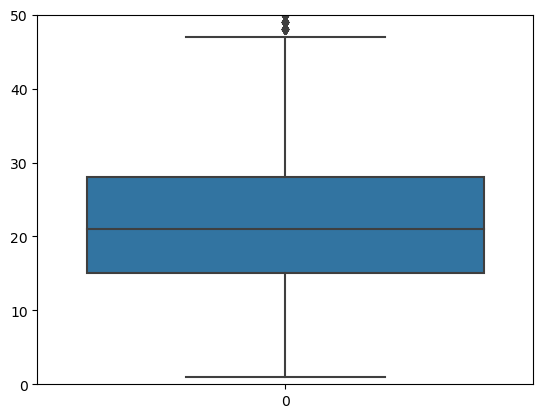

In [87]:
# Can't .diff() a DatetimeArray so do it manually. Remove the first one (and last to get matching lengths), then substract.

date_arr2 = date_arr1[:-1]
date_arr1 = date_arr1[1:]
granularity = date_arr1 - date_arr2
print(sorted(granularity, reverse = True)[:5])
print(sorted(granularity)[:5])
print(granularity.mean())

minutes_gran = [x.total_seconds()/60 for x in granularity]

sns.boxplot(minutes_gran)
plt.ylim(0, 50)
plt.plot()

# Time granularity is uneven, we should resample and pivot the table to have a timeseries dataframe
# We will identify the hole in the data in the following steps


## Setting up the main timeseries and dataframes

In [88]:
# No duplicate date for each stations so the aggfunc doesn't matter a lot 

available_ts_df = pd.pivot_table(df, index='date', columns='station_name', values='available', aggfunc='first')
operative_ts_df = pd.pivot_table(df, index='date', columns='station_name', values='operative', aggfunc='first')

#Resample to 30 minutes since it covers most of the deltas

available_ts_df = available_ts_df.resample('30T').min()
operative_ts_df = operative_ts_df.resample('30T').min()

# Create a geodataframe for station proximity

info_df = df.groupby(by='station_name')['station_geo'].first().str.split(',', expand=True).astype(float)
info_df.columns = ['lat', 'lon']
cap_df = df.groupby(by='station_name')['capacity'].max()

info_df = info_df.join(cap_df)

#### Displaying a few data

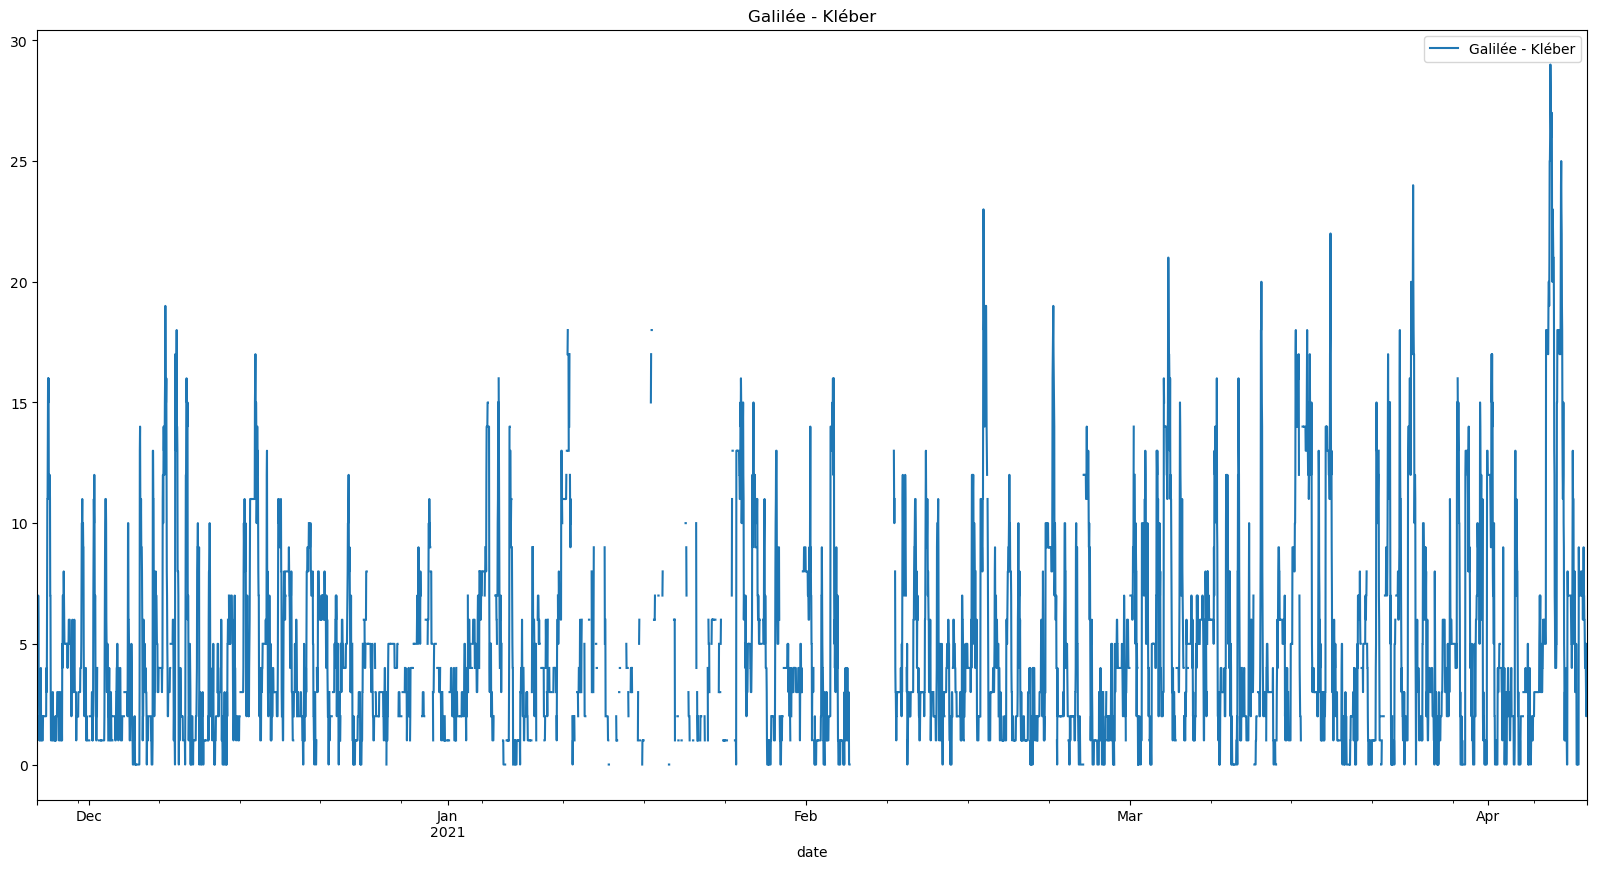

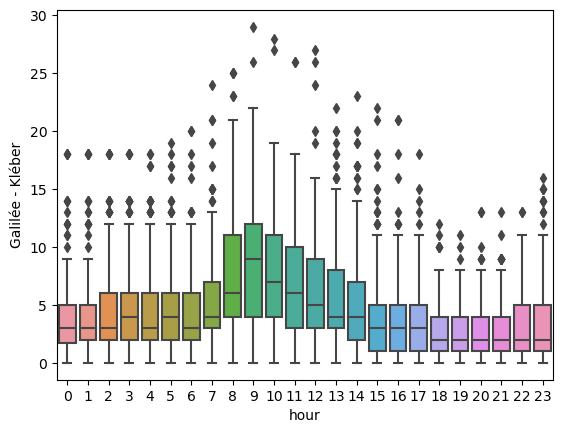

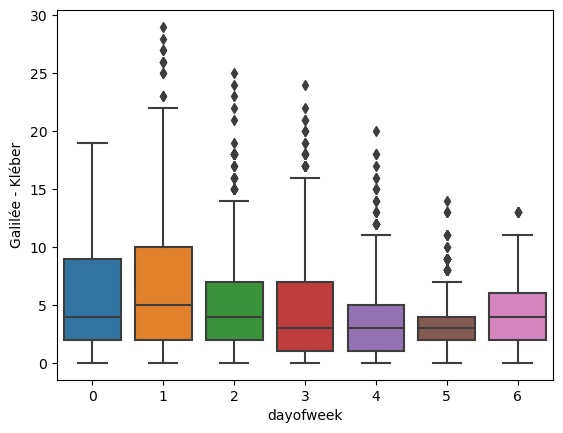

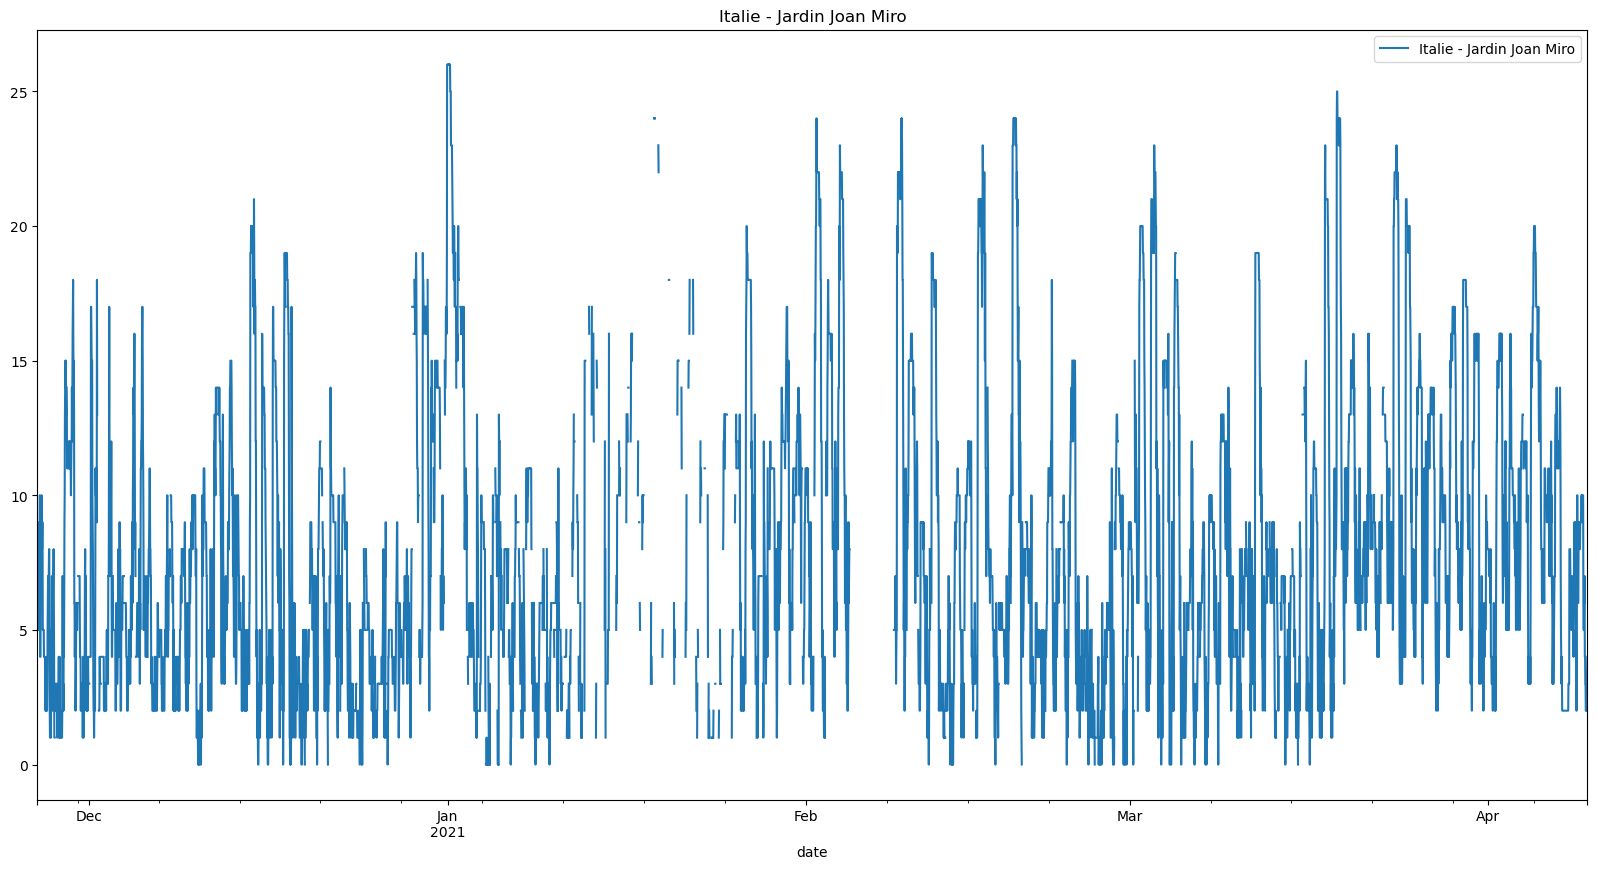

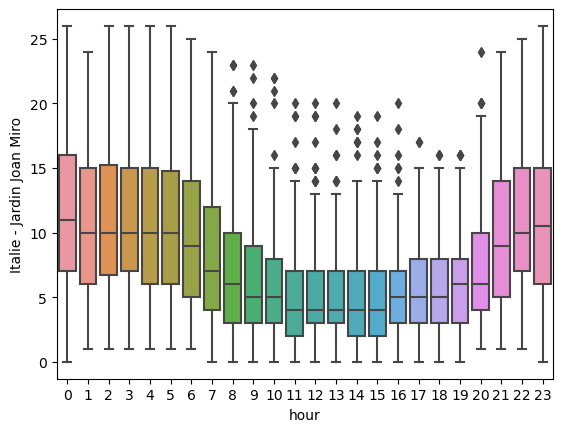

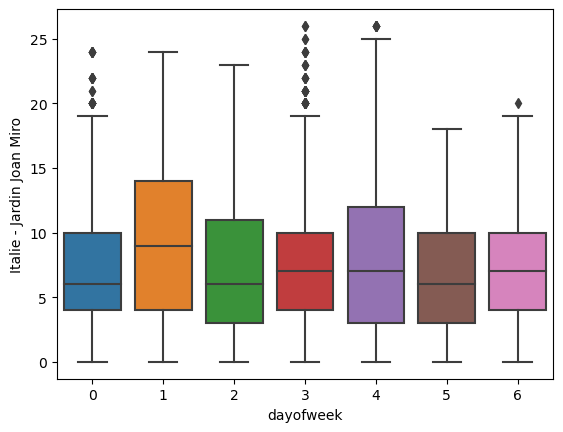

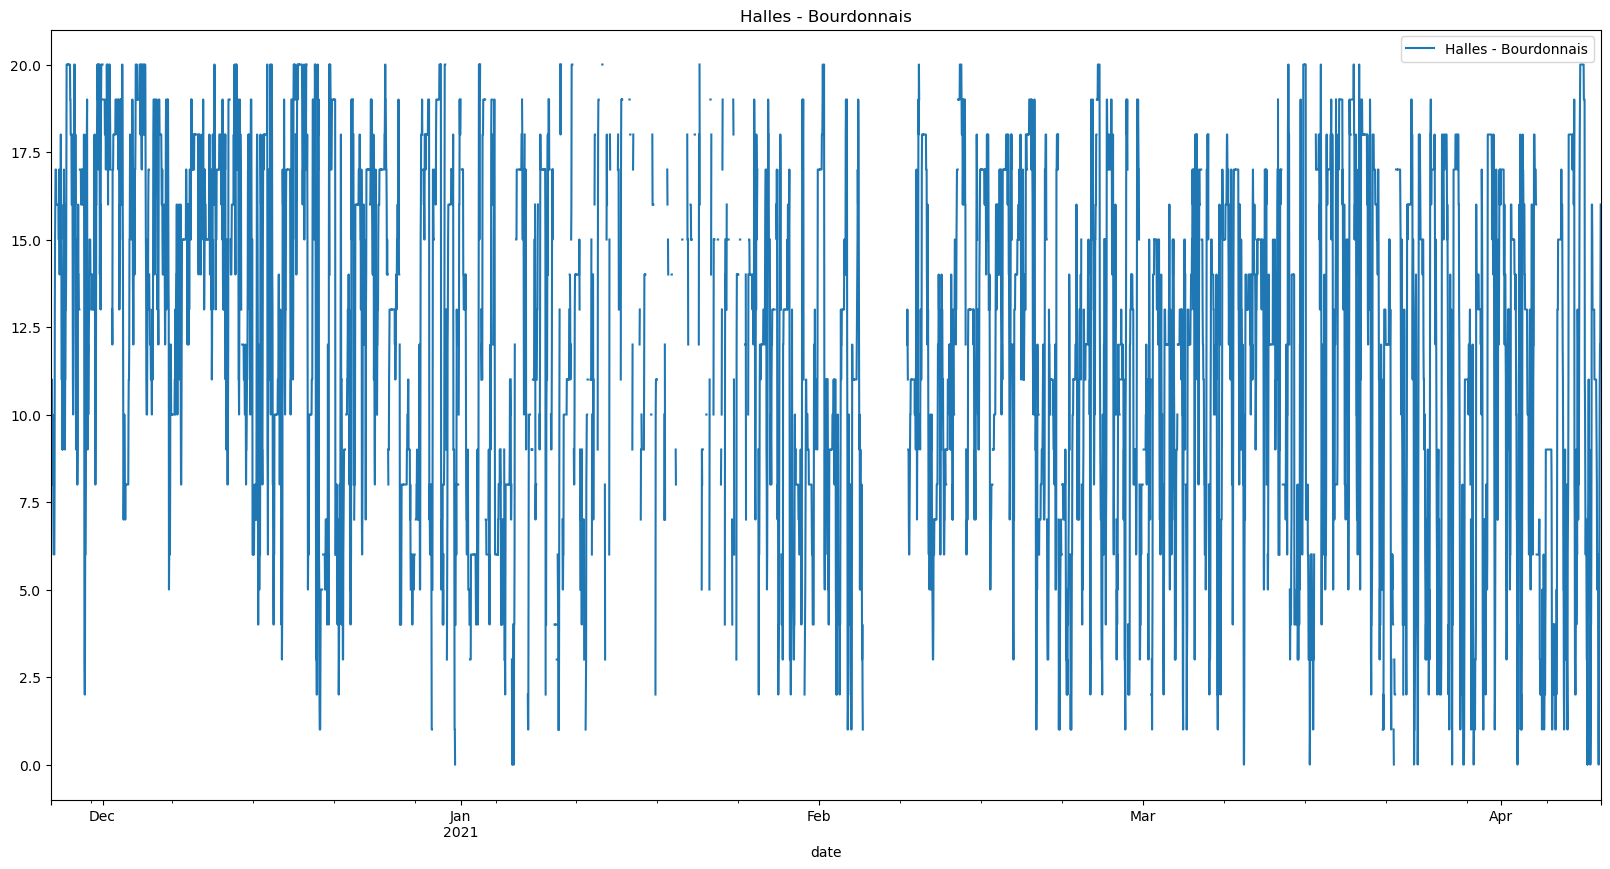

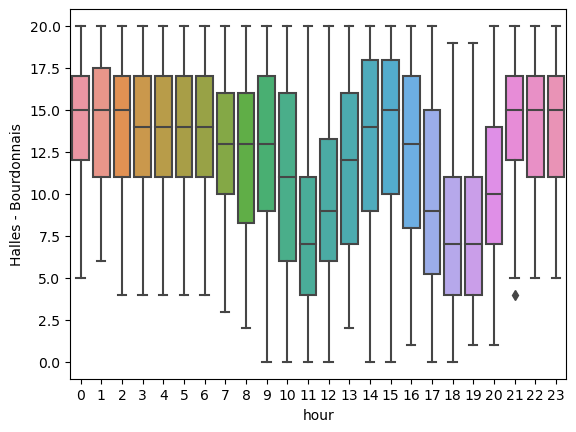

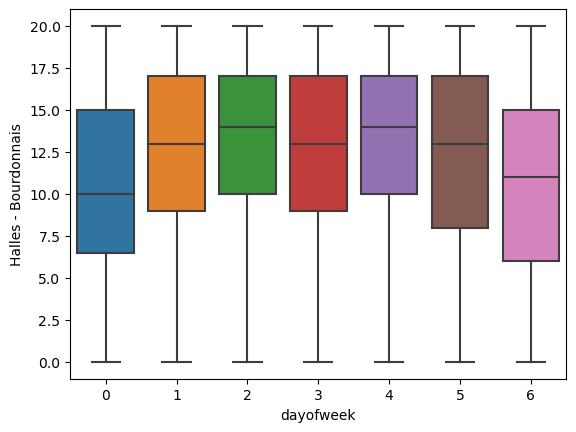

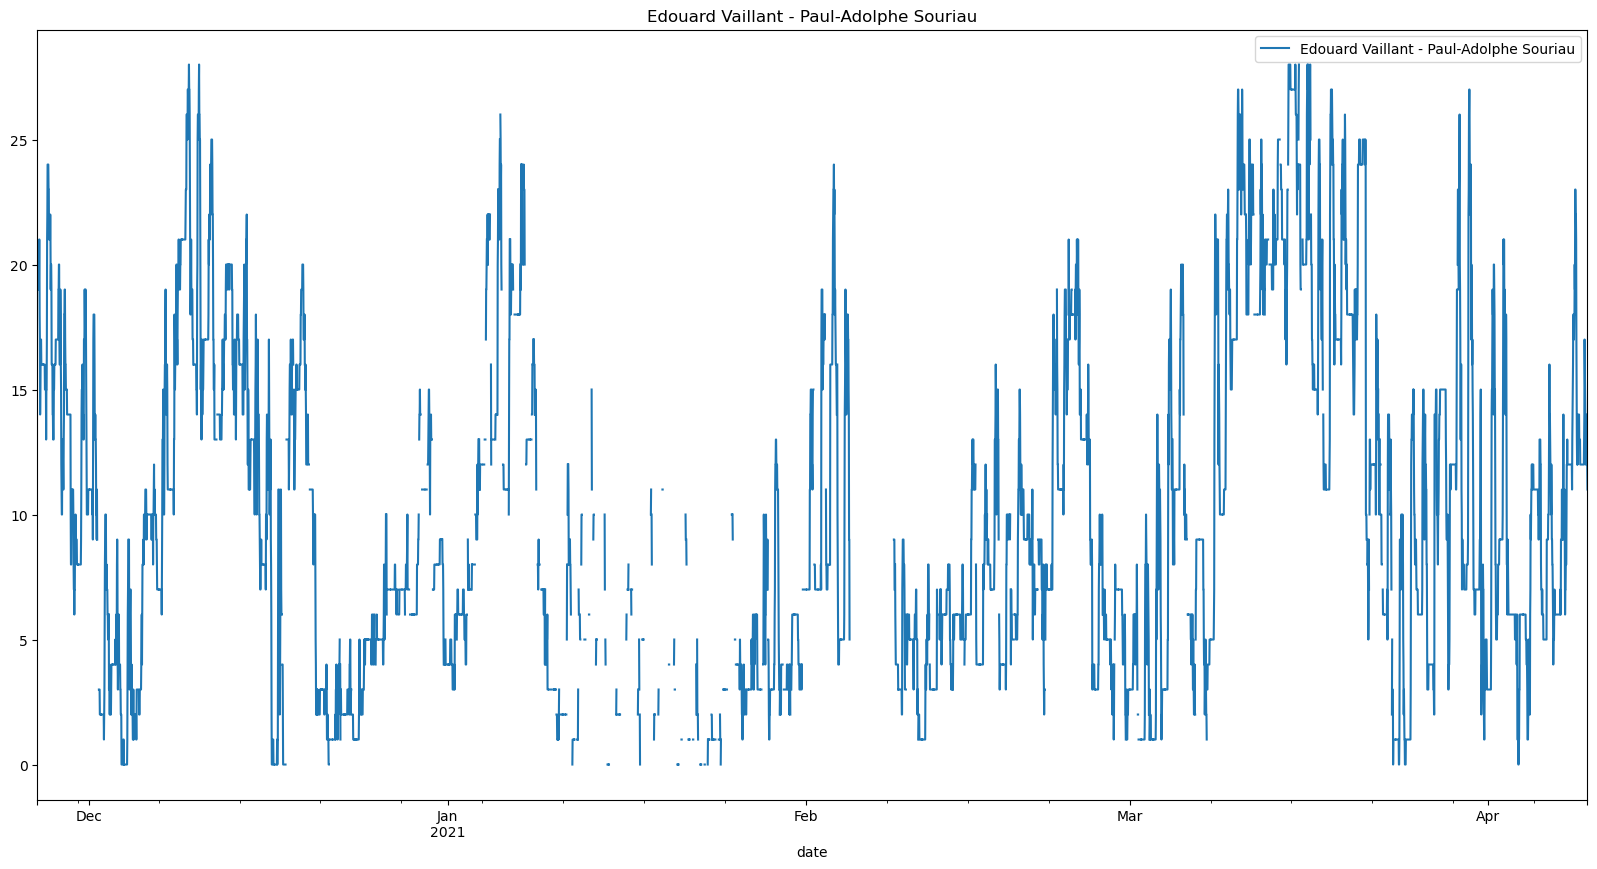

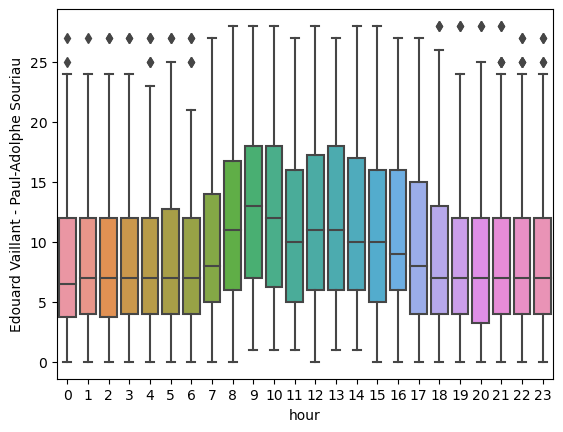

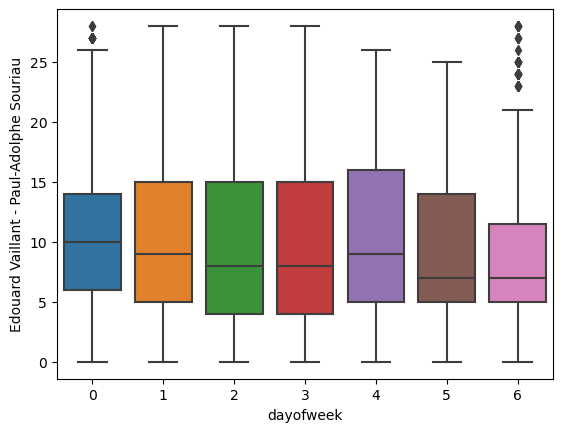

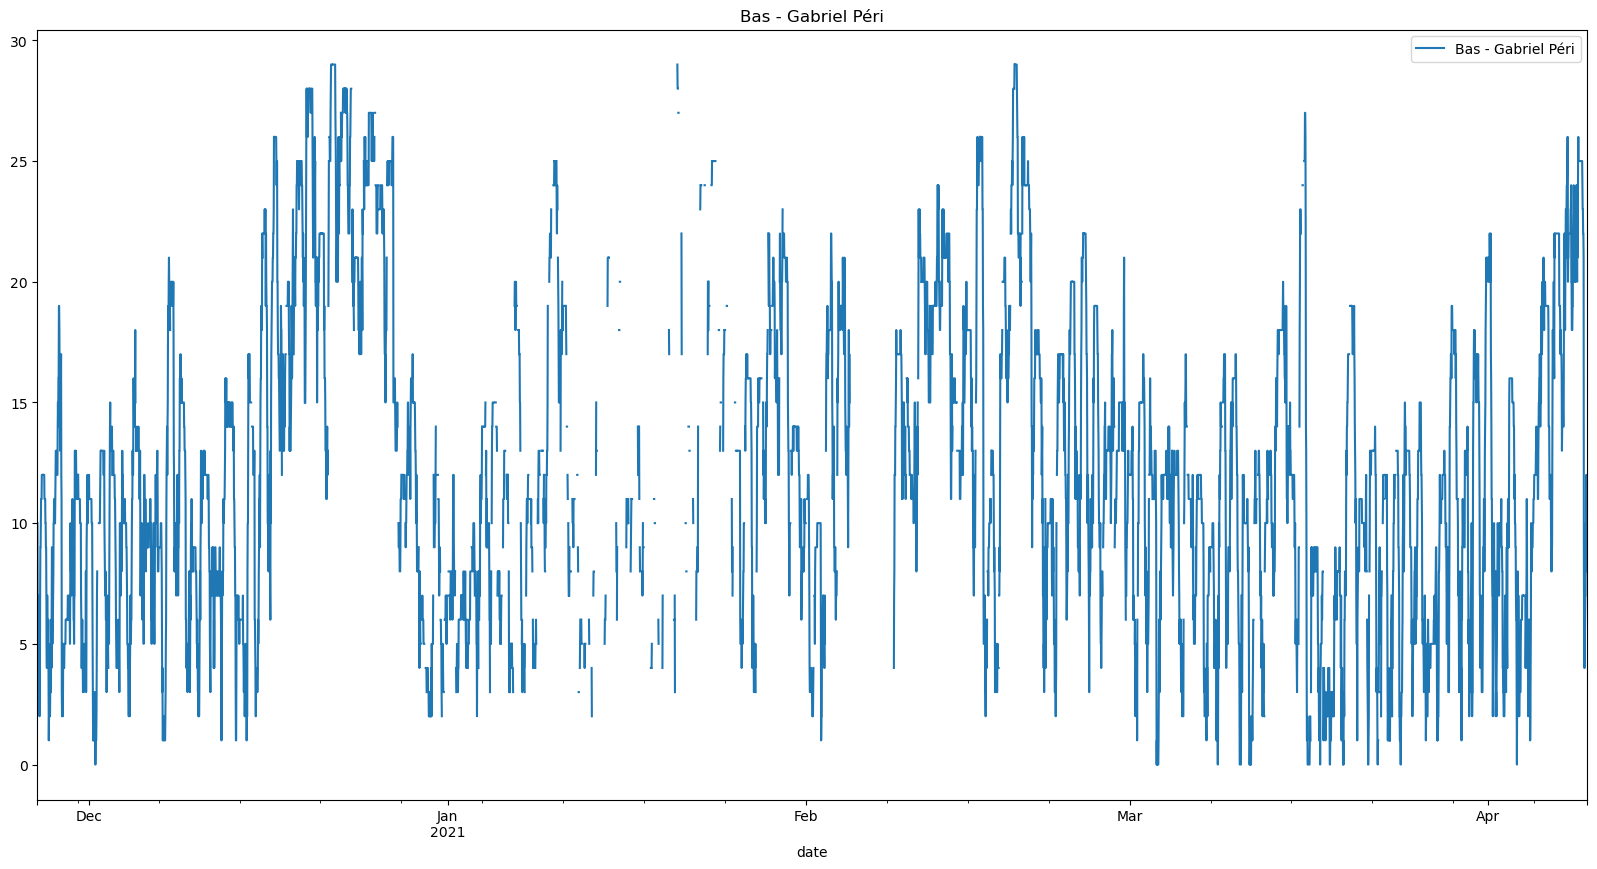

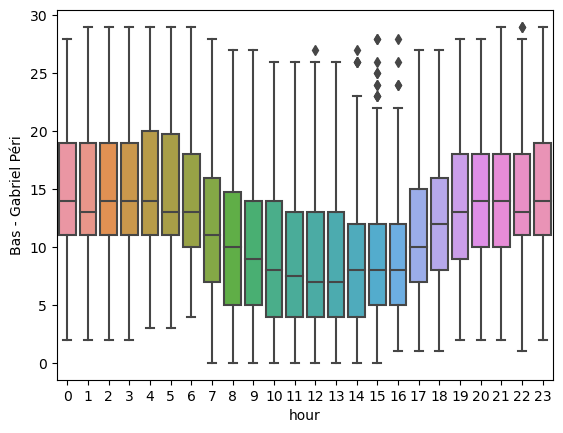

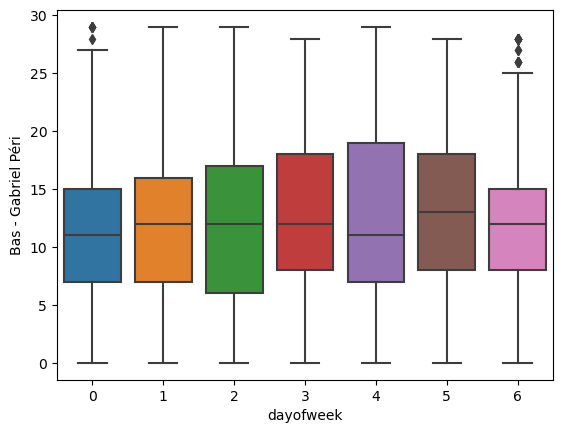

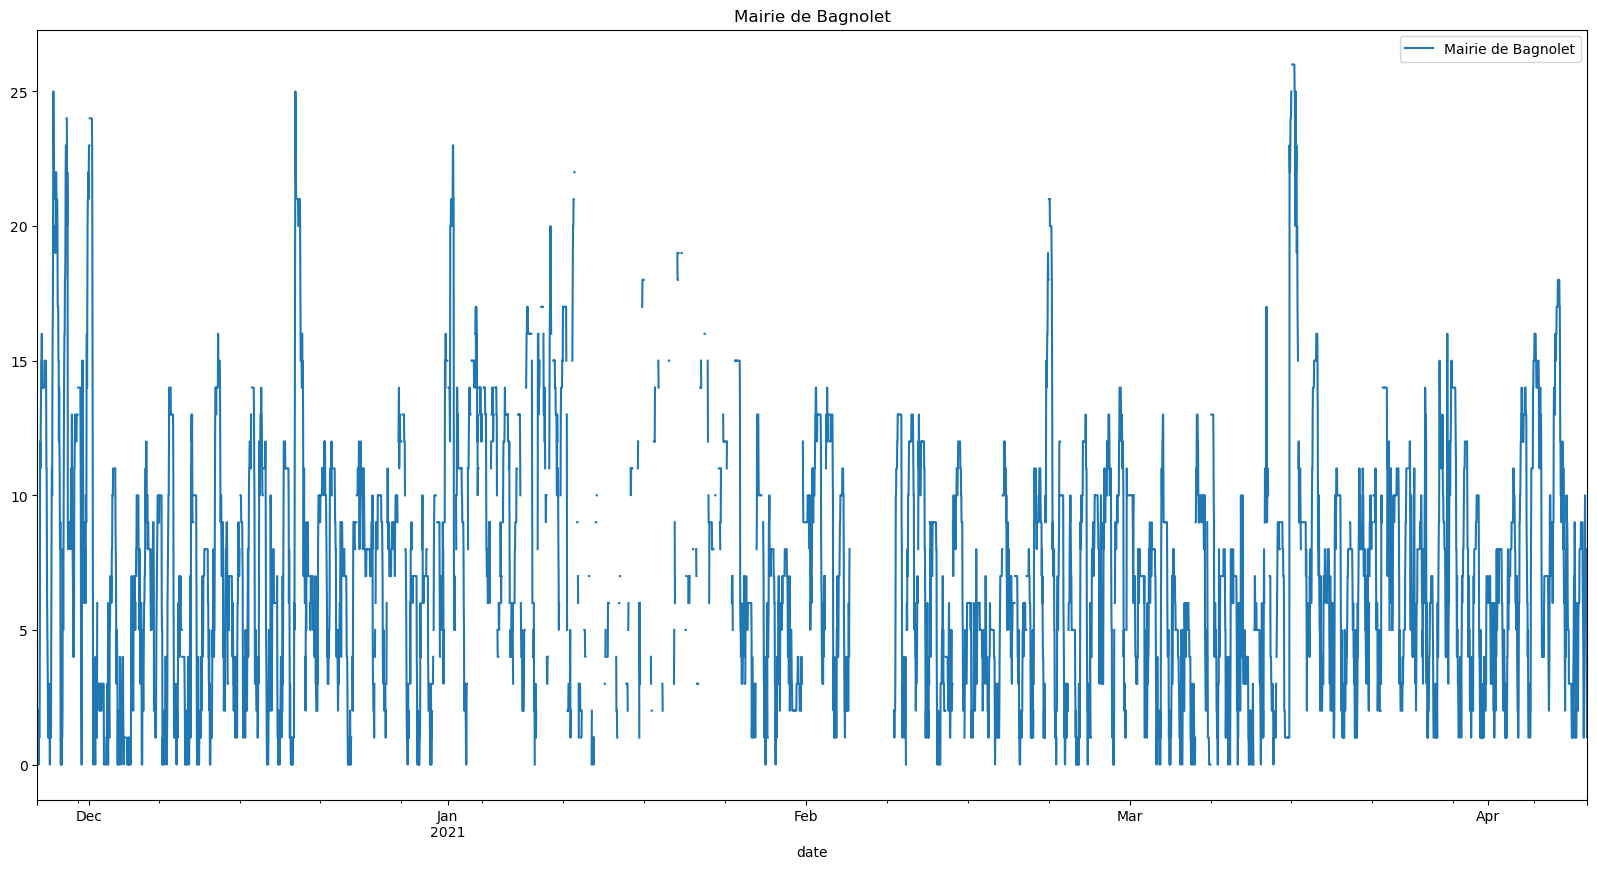

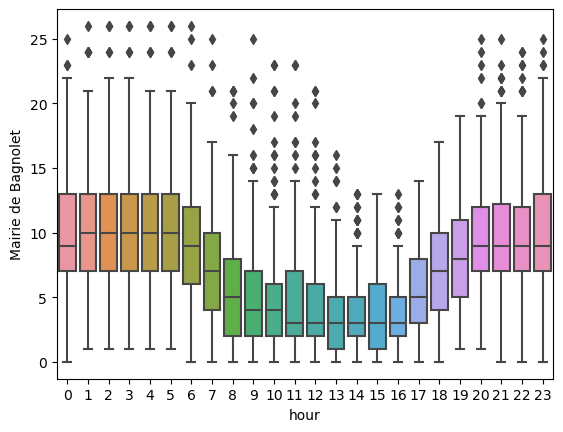

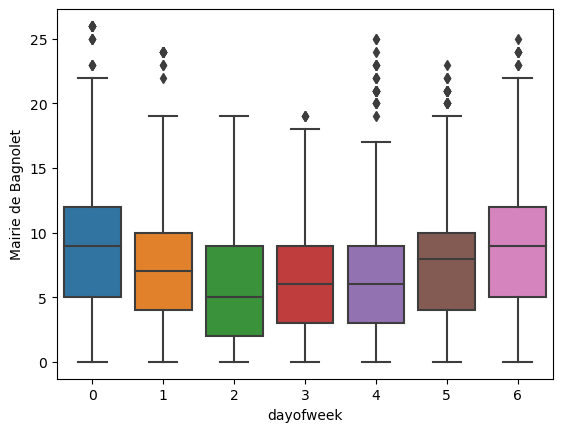

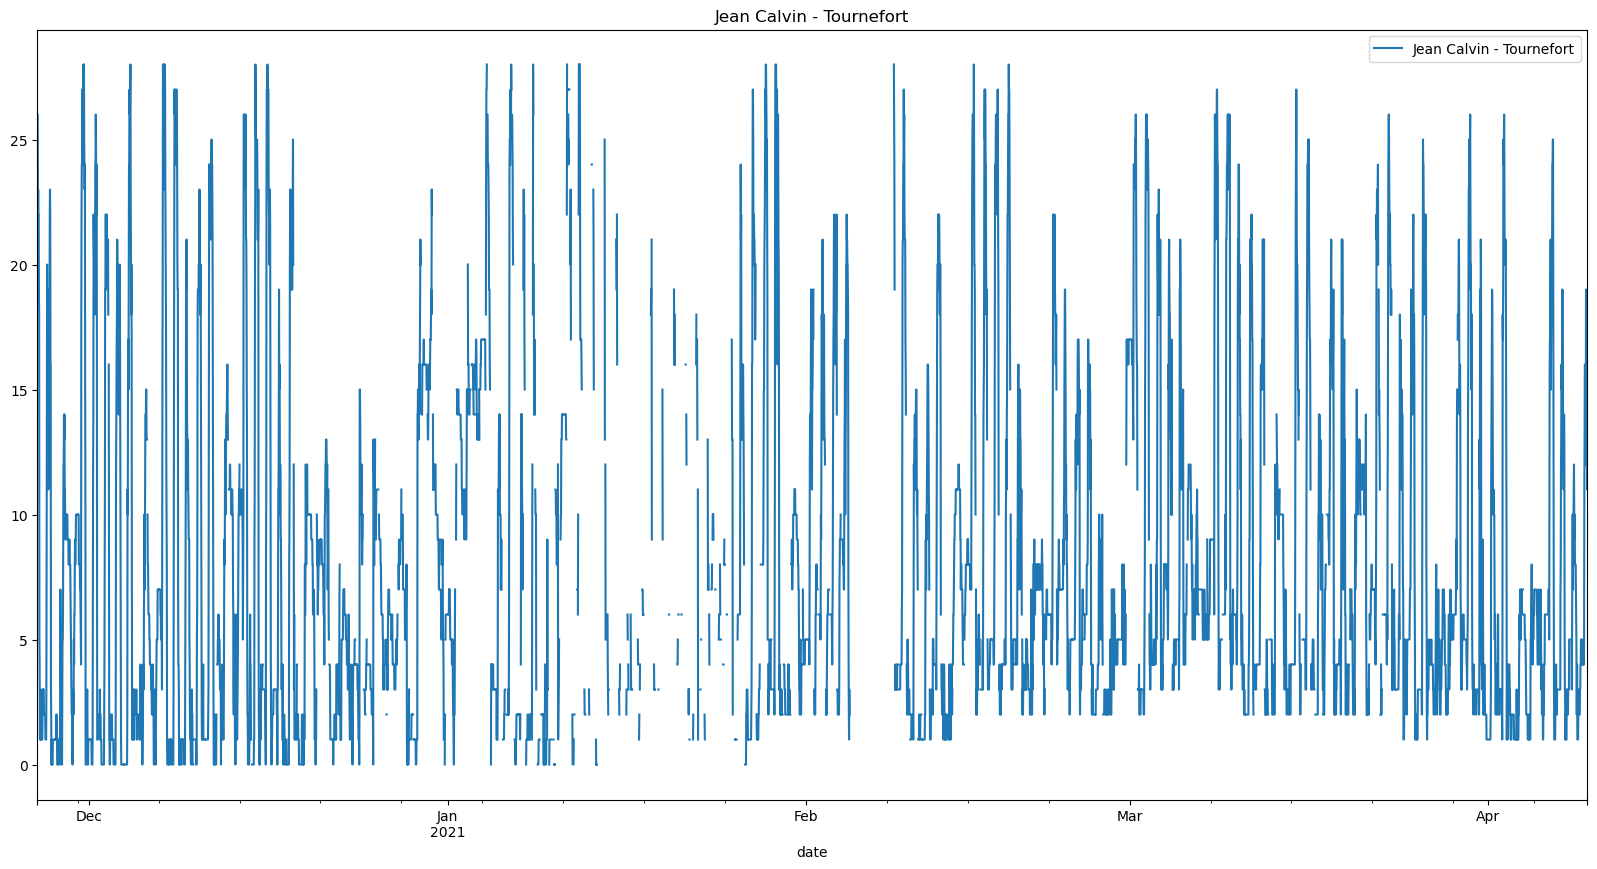

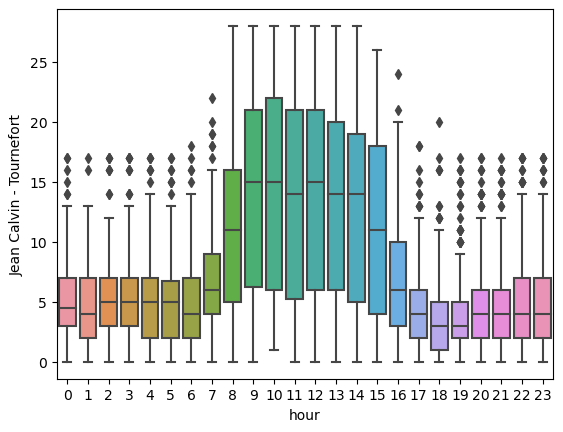

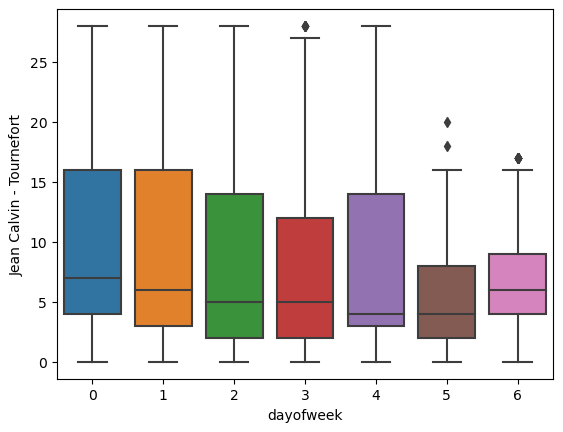

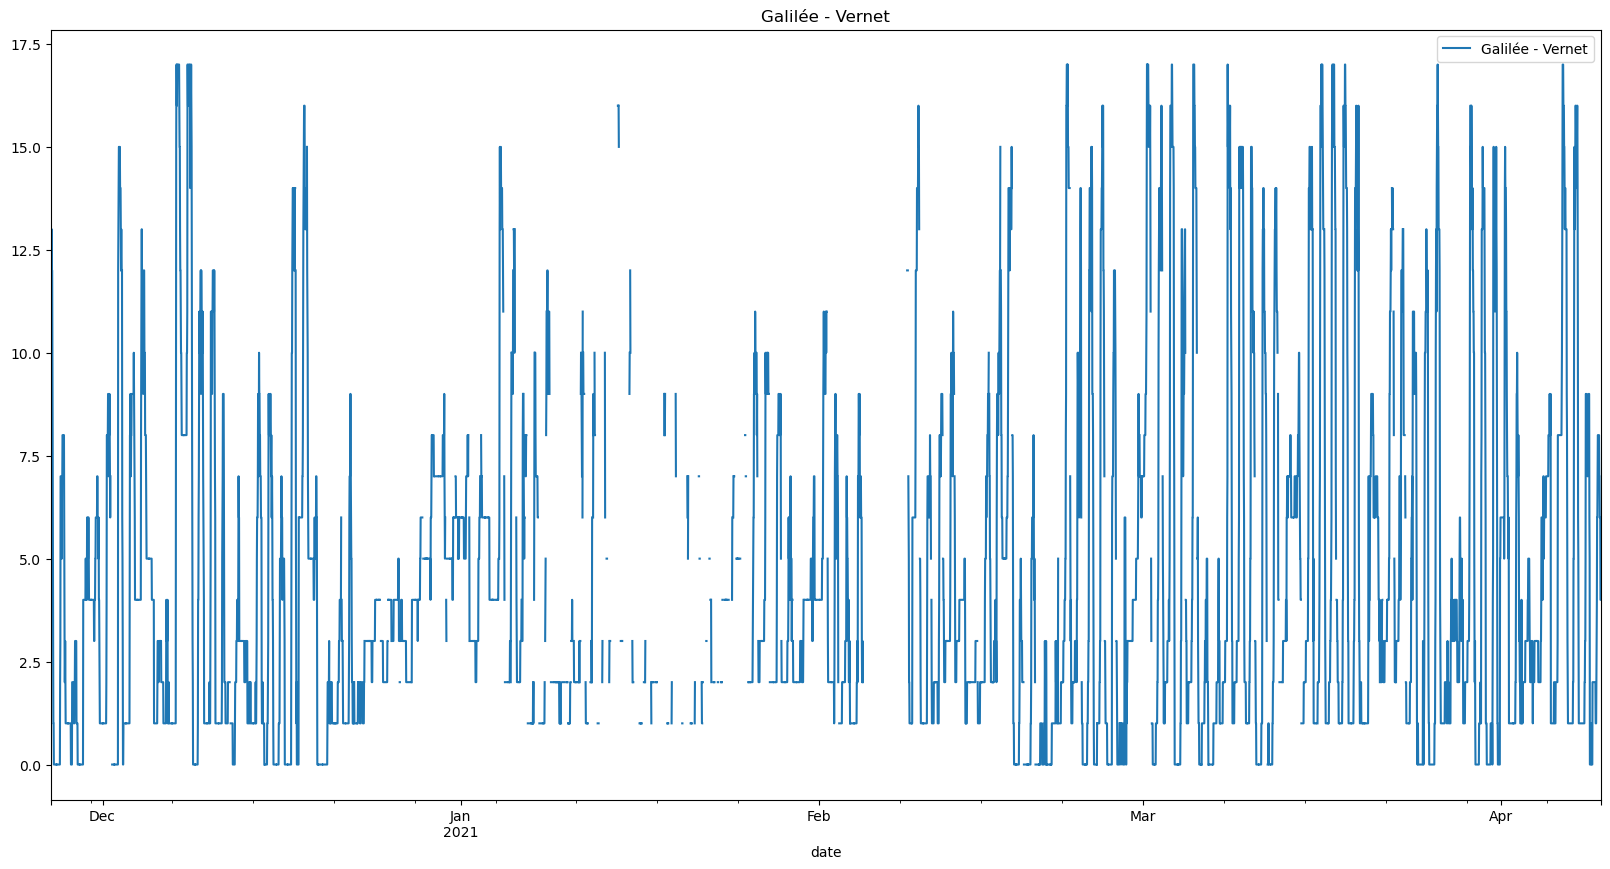

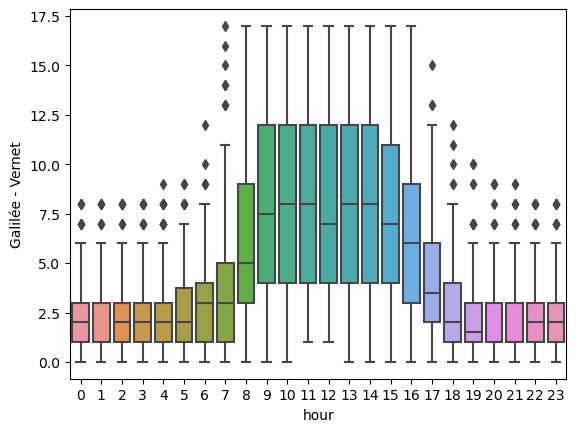

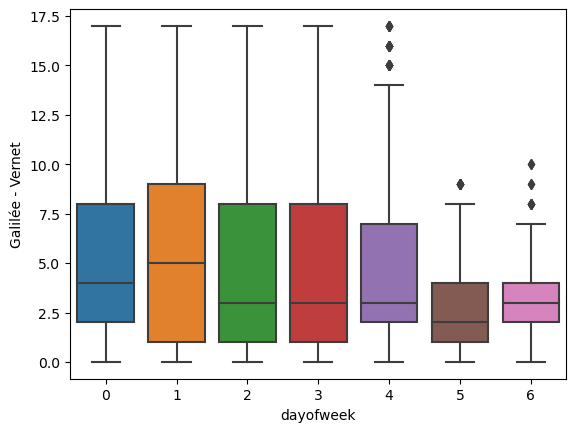

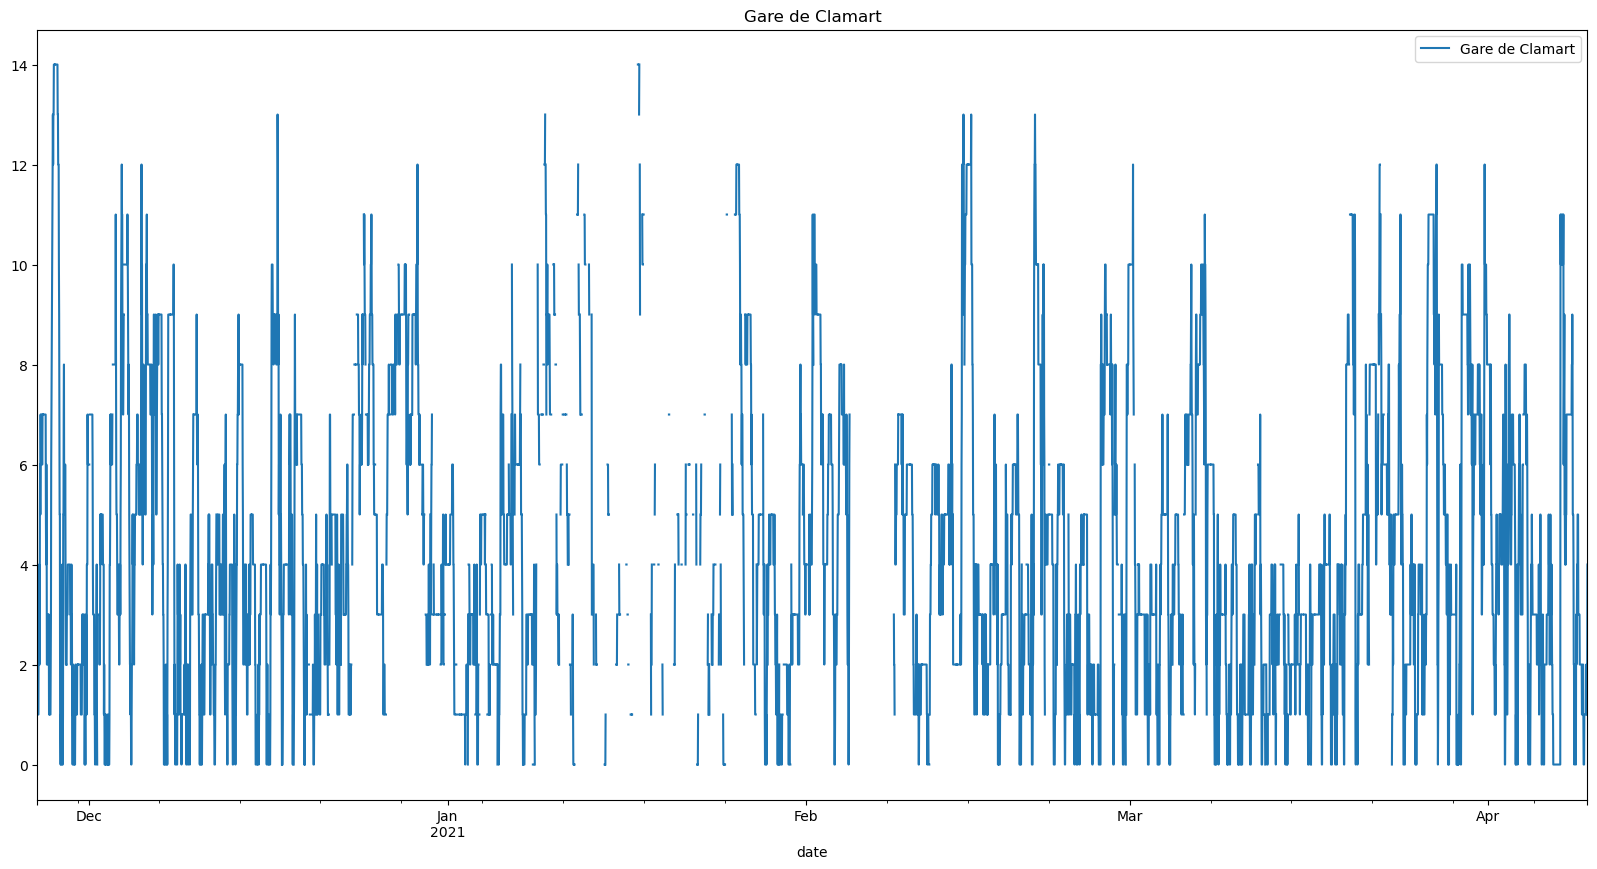

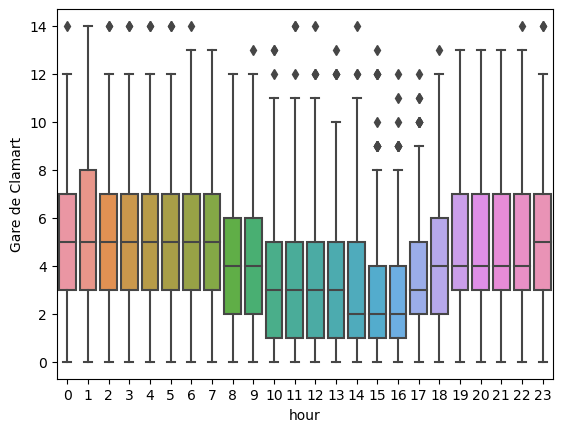

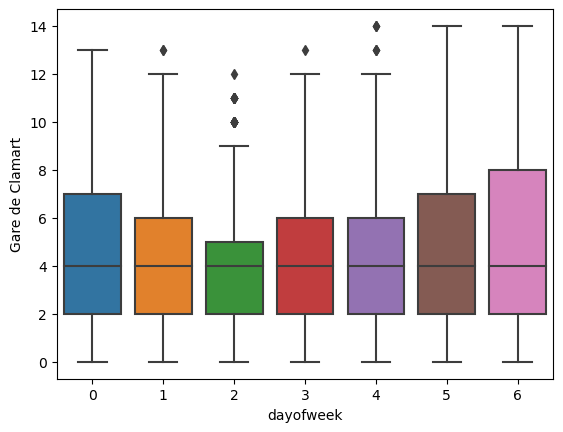

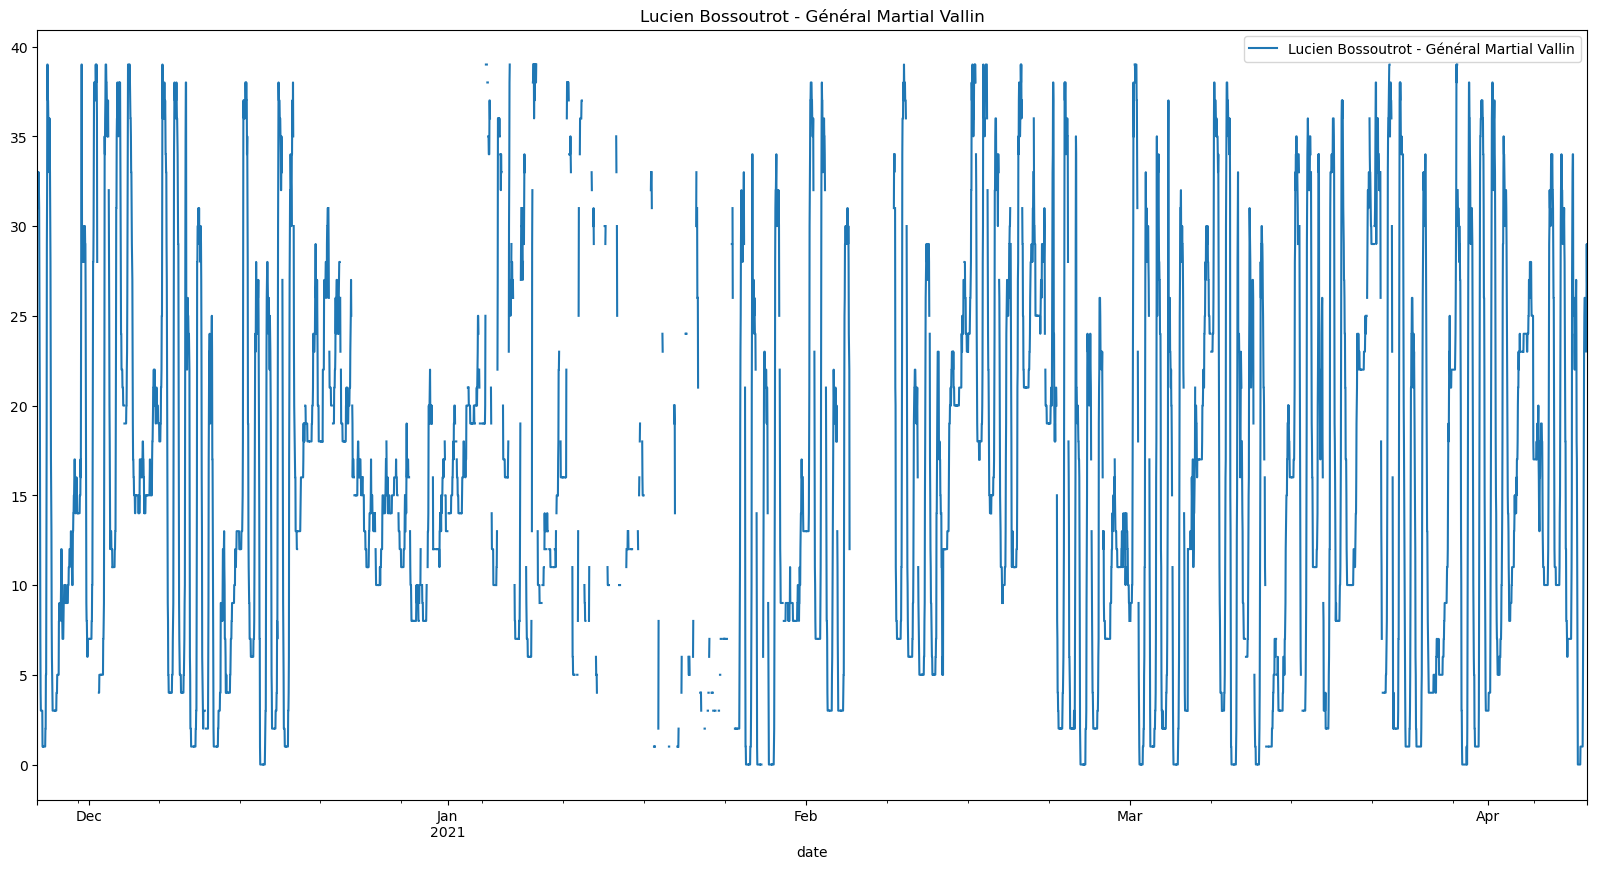

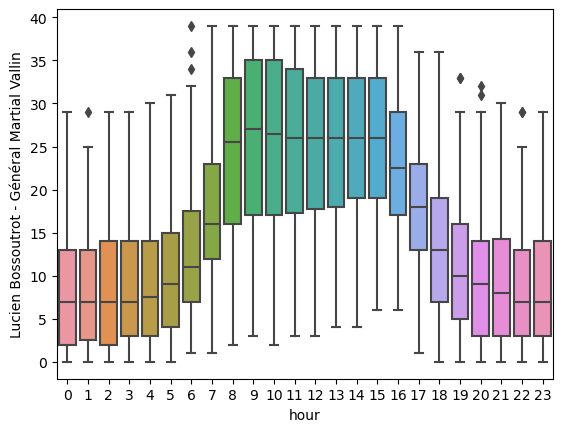

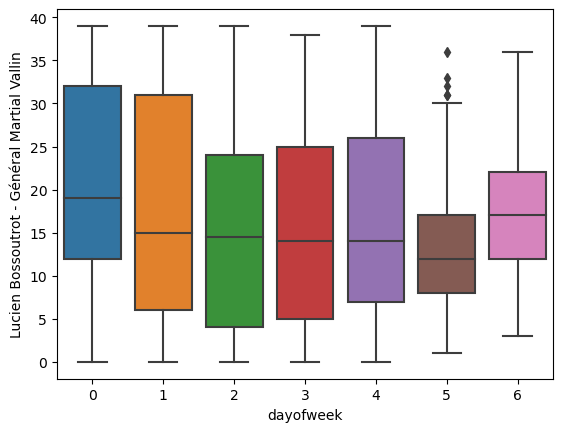

In [89]:
def disp(df, num):
    rand = [randint(0, len(df.columns)-1) for i in range(num)]
    
    for i in rand:
        col = df.columns[i]
        current_df = pd.DataFrame()
        current_df[df.columns[i]] = df[col]
        current_df.index = df.index
        
        current_df.plot(figsize=(20, 10))
        plt.title(col)
        plt.show()
        
        current_df['hour'] = df.index.hour
        current_df['dayofweek'] = df.index.dayofweek
        
        sns.boxplot(data = current_df, x = 'hour', y = col)
        plt.show()
        sns.boxplot(data = current_df, x = 'dayofweek', y = col)
        plt.show()

disp(available_ts_df, 10)

Some stations experiment seasonality (daily and weekly) and some don't. We consider the visual inspection to be enough and won't do a periodogram.

### Now identifying holes in the data 

In [90]:
# Randomly select stations and find where are the holes in it

def find_consec_nulls(df, num):
    rand = [randint(0, len(df.columns)-1) for i in range(num)]

    for i in rand:
        col = df.columns[i]
        current_df = df[col]
        display(current_df.isnull().astype(int).groupby(current_df.notnull().astype(int).cumsum()).sum().sort_values())
        
find_consec_nulls(available_ts_df, 5)

Paul Doumer - La Tour
1         0
3633      0
3632      0
3631      0
3630      0
       ... 
2274      3
4357      4
244       6
2444      6
2777    183
Name: Paul Doumer - La Tour, Length: 5504, dtype: int32

Gare du Nord - Faubourg Saint-Denis
1         0
3633      0
3632      0
3631      0
3630      0
       ... 
2274      3
4357      4
244       6
2444      6
2777    183
Name: Gare du Nord - Faubourg Saint-Denis, Length: 5504, dtype: int32

Sahel - Général Michel Bizot
1         0
3633      0
3632      0
3631      0
3630      0
       ... 
2274      3
4357      4
244       6
2444      6
2777    183
Name: Sahel - Général Michel Bizot, Length: 5504, dtype: int32

Gare Saint-Lazare - Cour du Havre
1         0
3633      0
3632      0
3631      0
3630      0
       ... 
2274      3
4357      4
244       6
2444      6
2777    183
Name: Gare Saint-Lazare - Cour du Havre, Length: 5504, dtype: int32

Gare de Clichy-Levallois
1         0
3633      0
3632      0
3631      0
3630      0
       ... 
2274      3
4357      4
244       6
2444      6
2777    183
Name: Gare de Clichy-Levallois, Length: 5504, dtype: int32

2777th index and the 183 following rows should be avoided. Other smaller holes will be filled with previous values so we can carry on.

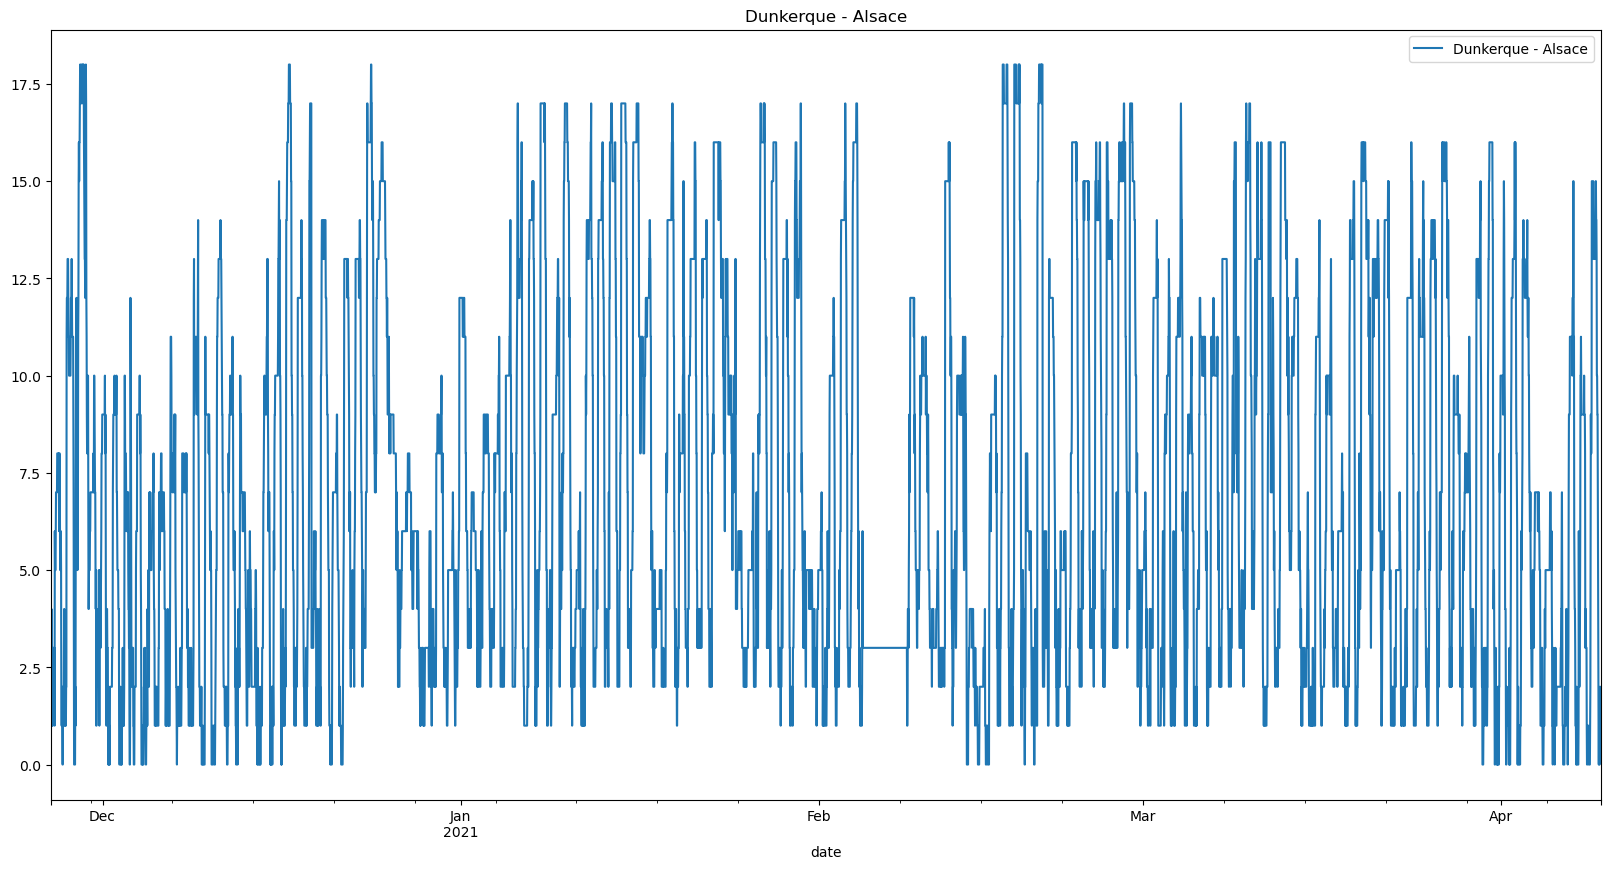

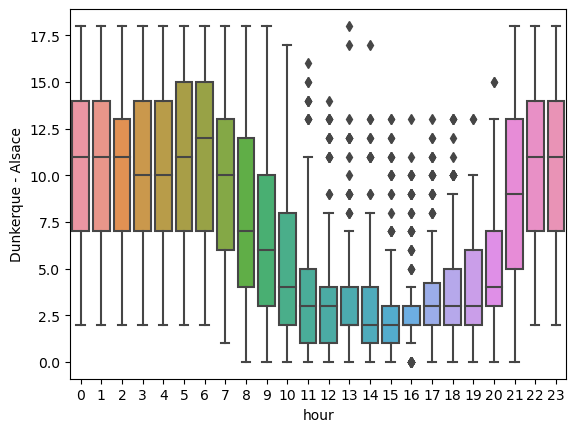

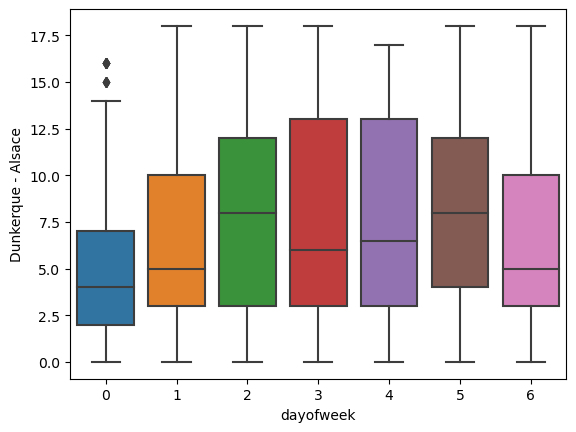

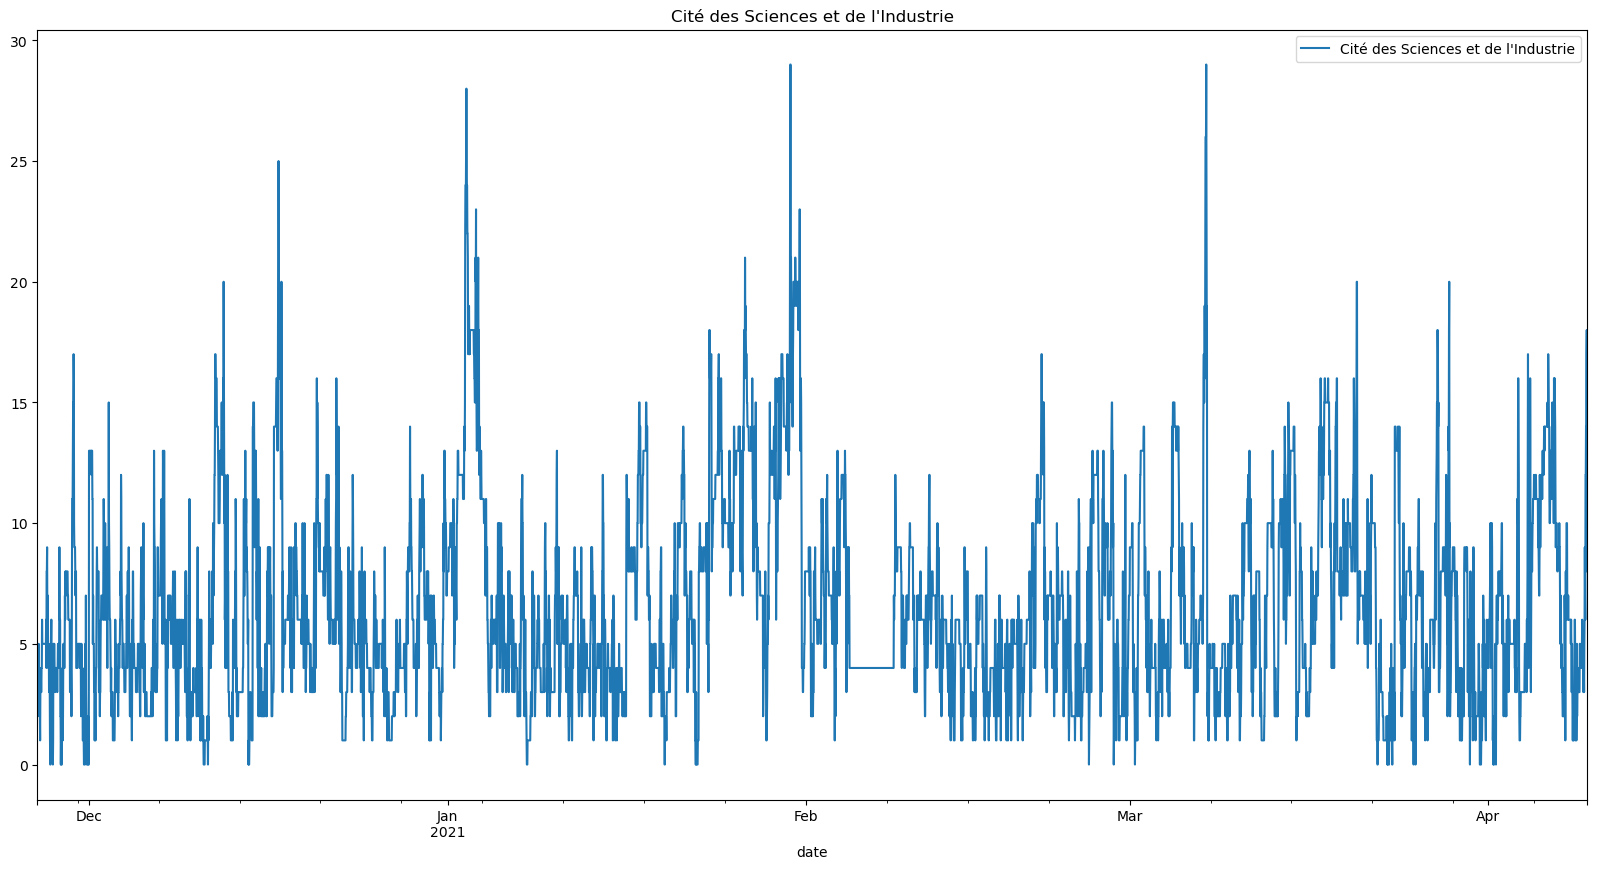

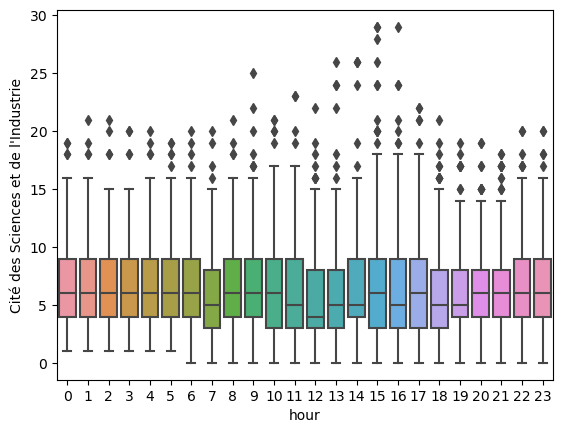

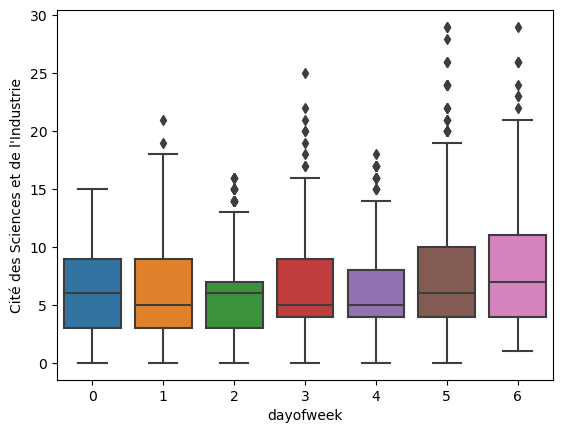

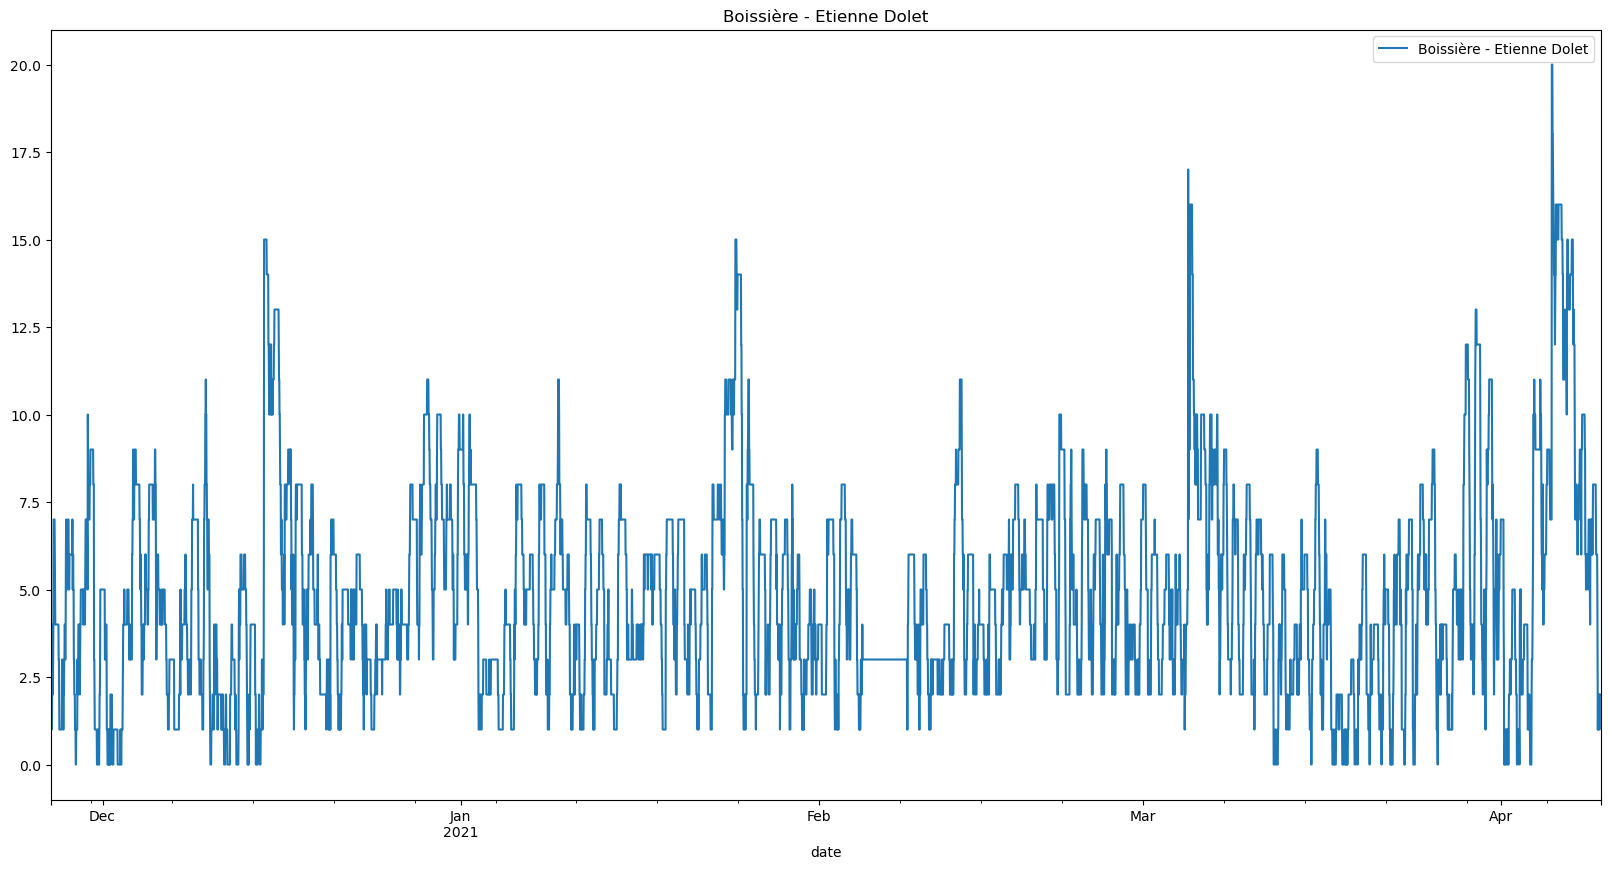

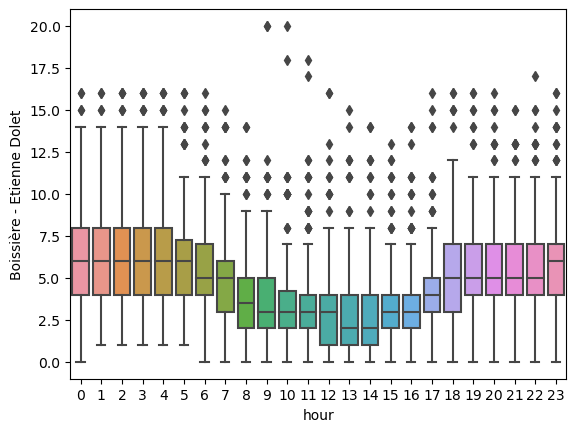

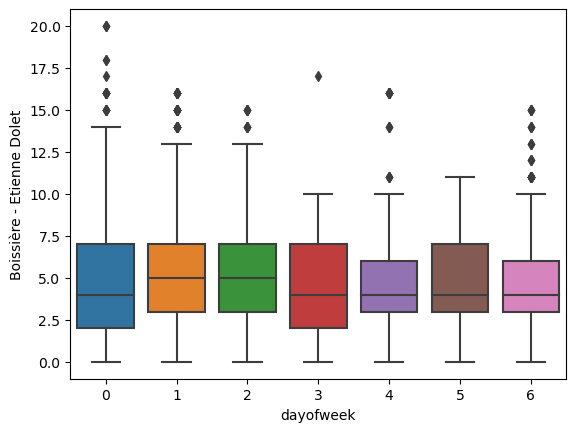

In [91]:
available_ts_df = available_ts_df.fillna(method='ffill')
operative_ts_df = operative_ts_df.fillna(method='ffill')

disp(available_ts_df, 3)

### Compute the distance between every stations to get an idea of the "neighbourness"

In [92]:
coordinates = info_df[['lat','lon']].astype(float).values

coordinates_array = np.array(coordinates)

dist_array = pdist(coordinates_array, lambda u, v: distance.distance(u, v).km)
dist_matrix = squareform(dist_array)

print(dist_matrix)


[[ 0.         26.74210169 10.65973585 ... 13.43994728 24.90569469
  22.06758628]
 [26.74210169  0.         18.19727326 ... 15.82775961  1.85280197
   6.58346137]
 [10.65973585 18.19727326  0.         ...  2.85277954 16.37128071
  15.52597374]
 ...
 [13.43994728 15.82775961  2.85277954 ...  0.         14.04270645
  13.94636433]
 [24.90569469  1.85280197 16.37128071 ... 14.04270645  0.
   5.48714724]
 [22.06758628  6.58346137 15.52597374 ... 13.94636433  5.48714724
   0.        ]]


In [93]:
dist_df = pd.DataFrame(dist_matrix, index = available_ts_df.columns, columns=available_ts_df.columns)
dist_df.replace(0, np.nan, inplace=True)

In [94]:
neighbours = {}
close_neighbours = {}

for col in dist_df.columns:
    close_neighbours[col] = dist_df[col][dist_df[col] < 0.5].index.values
    neighbours[col] = dist_df[col][dist_df[col] < 5].index.values


### Get the "activeness" of the stations

In [95]:
info_df['mean'] = (available_ts_df.diff().abs().mean()).T

display(info_df)

lat      lon  capacity      mean
station_name                                                               
11 Novembre 1918 - 8 Mai 1945         48.80890  2.53824        36  0.020044
18 juin 1940 - Buzenval               48.86881  2.18543        25  0.100839
8 Mai 1945 - 10 Juillet 1940          48.78457  2.39790        30  0.000000
Abbeville - Faubourg Poissonnière     48.87922  2.34915        14  0.866532
Abbé Carton - Plantes                 48.82767  2.32092        25  0.637042
...                                        ...      ...       ...       ...
Wurtz - Tolbiac                       48.82631  2.34459        28  1.107676
Youri Gagarine - Commune de Paris     48.78243  2.39397        33  0.991920
Youri Gagarine - Karl Marx            48.78448  2.35908        22  0.366221
Édouard Vaillant - Place Jean Jaurès  48.86266  2.20890        24  0.178682
Île de la Jatte                       48.89404  2.26663        23  0.546768

[1392 rows x 4 columns]

## Creating our datasets

In [96]:
from tqdm import tqdm

adf1 = available_ts_df[:2777]
adf2 = available_ts_df[2777+183:]

#A bit of feature engineering to take into consideration the moment of day / week
def datetime_to_seasonality(dt, max_val=1.0):
    day_of_week = dt.weekday()  # 0 (Monday) to 6 (Sunday)
    hour_of_day = dt.hour
    week_angle = (2 * np.pi * day_of_week) / 7
    day_angle = (2 * np.pi * hour_of_day) / 24
    
    week_sine = max_val * np.sin(week_angle)
    week_cosine = max_val * np.cos(week_angle)
    day_sine = max_val * np.sin(day_angle)
    day_cosine = max_val * np.cos(day_angle)
    
    return week_sine, week_cosine, day_sine, day_cosine

seasonality1 = [list(datetime_to_seasonality(dt)) for dt in adf1.index]
seasonality2 = [list(datetime_to_seasonality(dt)) for dt in adf2.index]

# Get info about close neighbours stations and further located stations to have an idea of the number of circulating bike
def get_info(col):
    c_neighbours = close_neighbours[col]
    a_neighbours = neighbours[col]
    infos = info_df.loc[col].to_dict()
    c_num = c_neighbours.size
    if c_num> 0:
        infos['c_cap'] = info_df[info_df.index.isin(c_neighbours)]['capacity'].sum()
    else:
        infos['c_cap'] = 0
    infos['a_cap'] = info_df[info_df.index.isin(a_neighbours)]['capacity'].sum()
    infos['c_num'] = c_num
    infos['a_neighbours'] = a_neighbours
    infos['c_neighbours'] = c_neighbours
    return infos
    
# Pretty ineficient way to create our dataset
# TODO : make it faster and more elegant
def create_individual(value, date, infos, df):
    c_available = 0
    c_num = 0
    if infos['c_cap'] > 0:
        c_available = infos['c_cap'] - df.loc[date][infos['c_neighbours']].sum()
    a_available = infos['a_cap'] - df.loc[date][infos['a_neighbours']].sum()
    indiv = list(infos.values())[:-2]
    indiv.append(c_available)
    indiv.append(a_available)
    return indiv
    
        
def create_dataset(df, offset, s):
    X = []
    Y = []
    columns = df.columns
    num_bar = len(columns) * len(df)-336-offset
    with tqdm(total=num_bar) as pbar:
        for col in columns:
            infos = get_info(col)
            serie = df[col]
            dates = serie.index
            
            # start the range at 335 so we can get the Y value of the preceeding week
            for i in range(335, len(dates) - offset):
                x = create_individual(serie[i], dates[i], infos, df)
                x.append(serie[i-335+offset])
                x.append(serie[i-47+offset])
                if np.sum(np.isnan(x+serie[i+offset])) == 0:
                    x = x + s[i]
                    X.append(x)
                    Y.append(serie[i+offset])
                pbar.update(1)
    return X, Y

X1, Y1 = create_dataset(adf1, 1, seasonality1)
X2, Y2 = create_dataset(adf2, 1, seasonality2)

X = X1 + X2
Y = Y1 + Y2

#X, Y = create_dataset(adf1[:600], 1, seasonality1)


 90%|██████████████████████████████████████████████████████████████▎      | 4372272/4839647 [1:42:05<10:54, 713.74it/s]


#### Save the datasets because current version of code takes a lot of time

In [97]:
X_data = np.array(X)
Y_data = np.array(Y)

X_file_path = 'data/dataset_X.npy'
Y_file_path = 'data/dataset_Y.npy'

np.save(X_file_path, X_data)
np.save(Y_file_path, Y_data)

#### Load the datasets (Optionnal)

In [103]:
X = np.load('data/dataset_X.npy')
Y = np.load('data/dataset_Y.npy')

print(len(X))

7769800


### We chose XGboost as our first model.

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid for grid search
param_grid = {
    'n_estimators': [300, 400],
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print(best_params)
best_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f'models/best_xgb_model_{current_date}.joblib'

# Save the best model to a file using joblib
joblib.dump(best_model, model_filename)

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 400}


['models/best_xgb_model_2023-08-11_23-23-42.joblib']

### Model evaluation

Best Model Mean Squared Error: 20.96
R-squared: 0.79


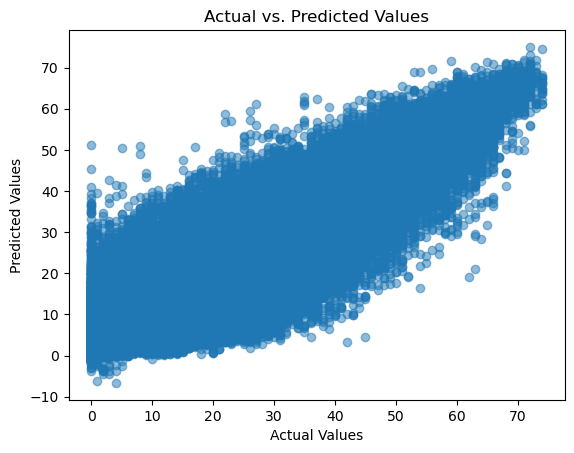

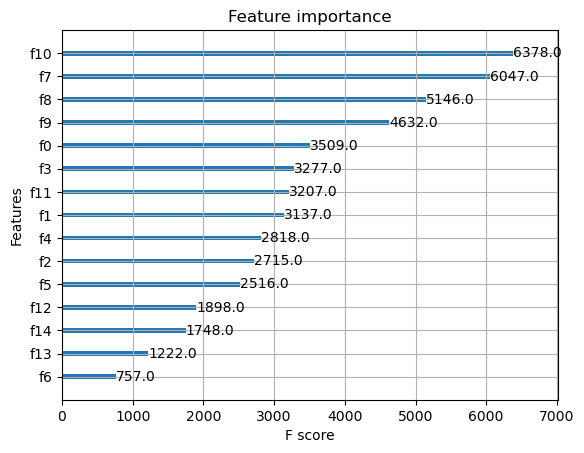

In [60]:
loaded_model = joblib.load(model_filename)

#model has to be fit after loading and not before for some reason
loaded_model.fit(X_train, Y_train)

Y_pred = loaded_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Best Model Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

xgb.plot_importance(loaded_model)
plt.show()


### Performances weren't that good after a few tries, we investigate neural networks

In [111]:
# Optional : decrease X and Y to start the process of building the network
X = X[:776980*2]
Y = Y[:776980*2].reshape(-1, 1)

xscaler = StandardScaler()
yscaler = StandardScaler()
X_scaled = xscaler.fit_transform(X)
Y_scaled = yscaler.fit_transform(Y)

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

# Build the MLP model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(X.shape[1],)))
model.add(tf.keras.layers.Dropout(0.1))  
model.add(tf.keras.layers.Dense(64, activation='swish'))
model.add(tf.keras.layers.Dropout(0.1))  
model.add(tf.keras.layers.Dense(128, activation='swish'))
model.add(tf.keras.layers.Dropout(0.1))  
model.add(tf.keras.layers.Dense(64, activation='swish'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1, activation='linear'))

# Compile and train
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/50
38849/38849 [==============================] - 79s 2ms/step - loss: 0.2856 - val_loss: 0.2408
Epoch 2/50
38849/38849 [==============================] - 75s 2ms/step - loss: 0.2717 - val_loss: 0.2329
Epoch 3/50
38849/38849 [==============================] - 74s 2ms/step - loss: 0.2660 - val_loss: 0.2436
Epoch 4/50
38849/38849 [==============================] - 76s 2ms/step - loss: 0.2627 - val_loss: 0.2329
Epoch 5/50
38849/38849 [==============================] - 74s 2ms/step - loss: 0.2599 - val_loss: 0.2346
Epoch 6/50
38849/38849 [==============================] - 74s 2ms/step - loss: 0.2576 - val_loss: 0.2326
Epoch 7/50
38849/38849 [==============================] - 74s 2ms/step - loss: 0.2561 - val_loss: 0.2286
Epoch 8/50
38849/38849 [==============================] - 74s 2ms/step - loss: 0.2552 - val_loss: 0.2275
Epoch 9/50
38849/38849 [==============================] - 75s 2ms/step - loss: 0.2537 - val_loss: 0.2282
Epoch 10/50
38849/38849 [==============================

In [109]:
def evaluate_MLP(X_val, Y_val):
    Y_pred_scaled = model.predict(X_val)
    Y_pred = yscaler.inverse_transform(Y_pred_scaled)
    Y_test = yscaler.inverse_transform(Y_val)

    print("Scaled :")
    mse = mean_squared_error(Y_val, Y_pred_scaled)

    print(f"Best Model Mean Squared Error: {mse:.2f}")
    print("NOT scaled :")
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)

    print(f"Best Model Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")

    plt.scatter(Y_test, Y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.show()

### Evaluate the MLP
(older version : 64-32 layer with 0.2 dropout)

4857/4857 [==============================] - 4s 862us/step
Scaled :
Best Model Mean Squared Error: 0.23
R-squared: 0.77
NOT scaled :
Best Model Mean Squared Error: 22.52
R-squared: 0.77


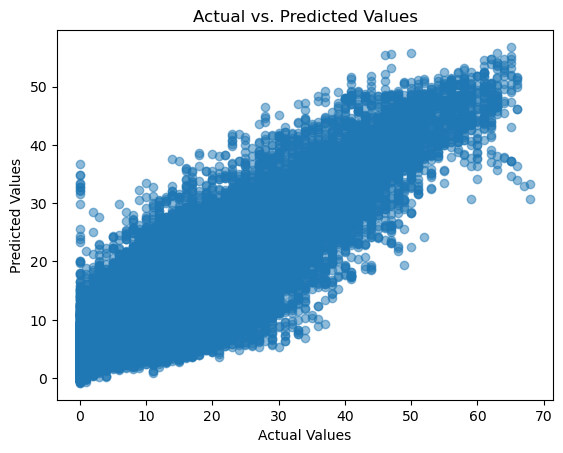

In [102]:
evaluate_MLP(X_val, Y_val)

#### Newer version (128-64-32 with 0.2 dropout) 
Better results (which suggest an underfitting)

9713/9713 [==============================] - 9s 899us/step
Scaled :
Best Model Mean Squared Error: 0.19
NOT scaled :
Best Model Mean Squared Error: 21.37
R-squared: 0.81


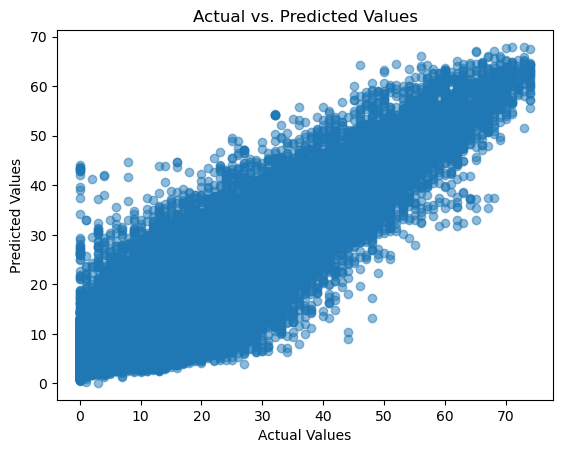

In [107]:
evaluate_MLP(X_val, Y_val)

#### Newest (and last) MLP (64-128-64, 0.2 dropout, swish activation func)

9713/9713 [==============================] - 11s 1ms/step
Scaled :
Best Model Mean Squared Error: 0.22
NOT scaled :
Best Model Mean Squared Error: 24.43
R-squared: 0.78


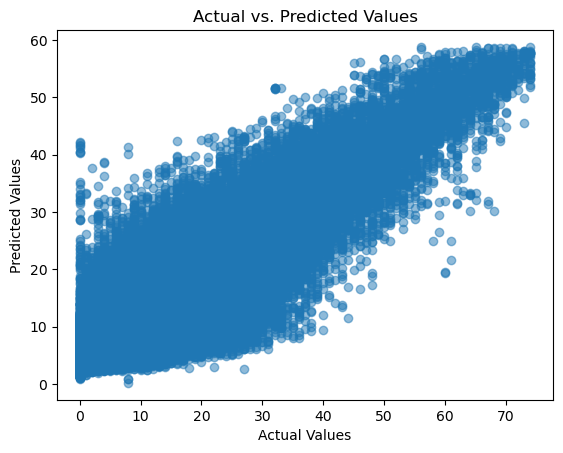

In [112]:
evaluate_MLP(X_val, Y_val)

### Next steps

All results are quite similar, more work should be done on the datasets.

Not doable :
- Sampling is at 30 minutes due to the data gathering, a smaller granularity might be beneficial

Doable :
- Investigate the delta between steps of the timeserie instead of total available places
- Change our approach and incorporate a convolution / reccurent approach
- Test every stations at once ? This should be a lot more expensive but models would have every informations at once and we wouldn't have to engineer feature about local stations